In [1]:
"""
Problem 2.1
"""

import pandas as pd
import numpy as np
import copy
import random
import matplotlib.pyplot as plt

In [2]:
# Loads the IRIS PLANT DATABASE:
iris_data = pd.read_csv('iris.data', header=None)
# Loads the PIMA INDIANS DIABETES DATABASE:
indians_data = pd.read_csv('pima-indians-diabetes.data', header=None)

In [3]:
"""
Implementation of the k-Nearest Neighbour algorithm
Parameters:
-train_set: The training set
-test_set: The test set
-k: k Nearest Neighbouts
Returns:
-test_pred: The test_set with an extra column in the end containing the predicted class for a given number k of k-NN
"""
def kNN(train_set,test_set,k): # train_set and test_set have the class of each row in the last column!
    
    # train: train_set without the last column containing the class labels
    train = train_set.drop(train_set.columns[[-1]],axis=1)
    
    # test: test_set without the last column containing the class labels    
    test = test_set.drop(test_set.columns[[-1]],axis=1)
    
    test_pred = copy.deepcopy(test_set)
    
    # Adds an extra column in the end of test_pred, named "Prediction":
    if type(test_pred.iloc[1,-1]) is str:   # if class labels are strings
        test_pred['Prediction'] = ""
    elif type(test_pred.iloc[1,-1]) is np.int64:   # if class labels are integers
        test_pred['Prediction'] = np.nan
    
    # Iterates over the rows of test:
    for index, row in test.iterrows():
        # Calculates the Euclidean distance between the row (point) of test and every row (point) in train
        diff = train.subtract(row,axis=1)
        dist = np.linalg.norm(diff.to_numpy(),axis=1)
        # Creates a dataframe dist_class, containing the distances calculated above in column "Distance"
        # and the respective class of every row (point) from train_set
        dist_class = pd.DataFrame({'Distance':dist,'Class':train_set.iloc[:,-1]})
        # Sorts dist_class based on the "Distance" values
        dist_class = dist_class.sort_values('Distance')
        dist_class = dist_class.reset_index(drop=True)
        
        # dist_class_k contains only the first k rows of dist_class
        dist_class_k = dist_class.iloc[:k,:]
        # pred is the most frequent class label in dist_class_k. In case of equifrequent classes, it randomly picks one
        pred = dist_class_k['Class'].value_counts().idxmax()
        # Adds the prediction (pred) for the specific row at the last column of test_pred
        test_pred.iat[index,-1] = pred
    return test_pred



"""
Implementation of the cross validation
Parameters:
-data_set: The dataset
-q: Number of folds
Returns:
-test_array: An array with dimensions (q)x(N/q) with each row containing the indices of the rows of the data_set that
will be the test set for the q-fold cross validation
"""
def cross_val(data_set,q): # q: repetitions of cross-validation (choose carefully so that N%q=0 !!!)
    N = data_set.shape[0]
    N_cv = int(N/q)
    N_train = N - N_cv
    
    # list with all the indices (N) of the data_set rows
    all_data = list(range(N))
    test_array = np.zeros((q,N_cv))
    
    for t in range(q):
        # Selects N_cv random indices
        cv_rows = random.sample(all_data,N_cv)
        # Removes those indices so they don't get picked again in the test sets
        for i in cv_rows:
            all_data.remove(i)
        test = np.array(cv_rows)
        test_array[t,:] = test
    # turns all elements in test_array into integers
    test_array = np.int_(test_array)
    return test_array


"""
Solution for Problem 2 - Exercise 1 (returns a (k_max)x2 array, with the 1st column containing the k's
and the 2nd column containing the percentage of correct class prediction from k=1 to k=k_max, respectively):
q: repetitions of cross-validation (choose carefully so that N%q=0 !!!)
k_max: maximum number of kNN-neighbours to test 
"""
def main(data_set,q,k_max):
    # Calls the cross_val function
    cv_array = cross_val(data_set,q)
    # Initialization of k_correct
    k_correct = np.zeros((q,k_max))
    # Calculates the correct predictions for k=1 to k=k_max, for every training and test set combination (q in total):
    for m in range(q):
        cv_row = cv_array[m,:]
        cv = data_set.iloc[cv_row,:]
        cv = cv.reset_index(drop=True) # cross-validation set (test set)
        training = data_set.drop(data_set.index[cv_row])
        training = training.reset_index(drop=True) # training set
        
        for k in range(1,k_max+1):
            # calls kNN function
            prediction = kNN(training,cv,k)
            # calculates the correct predictions
            correct = sum(prediction.iloc[:,-2] == prediction.iloc[:,-1])
            # adds the number of correct predictions in k_correct
            k_correct[m,k-1] = correct
    # Sums the number of correct predictions for each k
    k_correct = np.sum(k_correct,axis=0)
    # Calculates the percentage of correct predictions
    k_correct = (k_correct/data_set.shape[0])*100
    # Dataframe with the 1st column containing the k's and the 2nd containing the percentage of correct predictions
    ans = pd.DataFrame({'k-NN':np.array(range(1,k_max+1)), 'Correct prediction %': np.round(k_correct,1)})
    # Returns index of the maximum percentage of correct prediction
    idx = ans[['Correct prediction %']].idxmax()
    return ans, idx



"""
The plot_results function plots the result from the function prob2_ex1
data: data returned from function prob2_ex1
dt_name: 'iris' or 'indians'
"""
def plot_results(data, dt_name):
    plt.plot(data.iloc[:,0],data.iloc[:,1], color='r')
    plt.xlabel("Number of Nearest Neighbours")
    plt.ylabel("% Correct Classification")
    if dt_name == 'iris':
        plt.suptitle("Iris Plant Database", y = 1.02, fontsize = 18)
    elif dt_name == 'indians':
        plt.suptitle("Pima Indians Diabetes Database", y = 1.02, fontsize = 18)
    plt.title("Percentage of Correct Classification Vs. Number of Nearest Neighbours", fontsize = 10)
    plt.grid()
    plt.show()

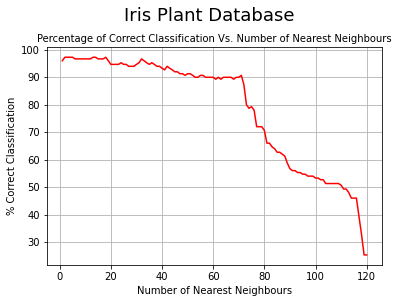

The optimal k for k-NN classification is: 

 k-NN  Correct prediction %
    2                  97.3


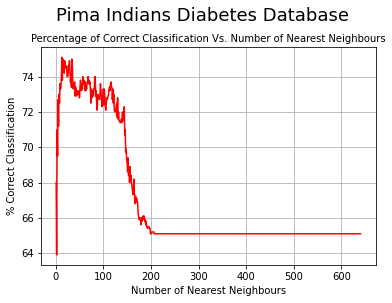

The optimal k for k-NN classification is: 

 k-NN  Correct prediction %
   13                  75.1


In [4]:
# Answer for Problem 2/Exercise 1/a with 5-fold cross-validation:
q = 5
k_maximum = int(iris_data.shape[0] - iris_data.shape[0]/q)
iris, index = main(iris_data,q,k_maximum)
plot_results(iris, 'iris')
optimal = iris.iloc[index,:].to_string(index=False)
print("The optimal k for k-NN classification is: \n")
print(optimal)


# Answer for Problem 2/Exercise 1/b with 6-fold cross-validation:
q2 = 6
k_maximum2 = int(indians_data.shape[0] - indians_data.shape[0]/q2)
indians, index2 = main(indians_data,q2,k_maximum2)
plot_results(indians, 'indians')
optimal2 = indians.iloc[index2,:].to_string(index=False)
print("The optimal k for k-NN classification is: \n")
print(optimal2)